In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
# import coremltools
print(tf.__version__)
print(tf.config.list_physical_devices())

ModuleNotFoundError: No module named 'scipy'

In [5]:
training_data_dir = '/tmp/cats-and-dogs/training_set/training_set/'
test_data_dir = '/tmp/cats-and-dogs/test_set/test_set/'

img_shape = (300, 300, 3)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
training_set = datagen.flow_from_directory(
    directory=training_data_dir, 
    target_size=(300, 300), 
    classes=['dogs', 'cats'], 
    class_mode='binary',
    batch_size=128
)
test_set = datagen.flow_from_directory(
    directory=test_data_dir, 
    target_size=(300, 300), 
    classes=['dogs', 'cats'], 
    class_mode='binary',
    batch_size=128
)

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [3]:
 model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                           input_shape=(300,300,3)),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
 ])
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [4]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

In [5]:
history = model.fit(training_set, epochs=5, validation_data=test_set)

Epoch 1/5
63/63 [==============================] - 264s 4s/step - loss: 0.6914 - accuracy: 0.5183 - val_loss: 0.6891 - val_accuracy: 0.5566
Epoch 2/5
63/63 [==============================] - 221s 4s/step - loss: 0.6832 - accuracy: 0.5603 - val_loss: 0.6730 - val_accuracy: 0.5957
Epoch 3/5
63/63 [==============================] - 222s 4s/step - loss: 0.6701 - accuracy: 0.5881 - val_loss: 0.6694 - val_accuracy: 0.5769
Epoch 4/5
63/63 [==============================] - 222s 4s/step - loss: 0.6644 - accuracy: 0.5918 - val_loss: 0.6588 - val_accuracy: 0.5937
Epoch 5/5
63/63 [==============================] - 218s 3s/step - loss: 0.6625 - accuracy: 0.5991 - val_loss: 0.6555 - val_accuracy: 0.6031


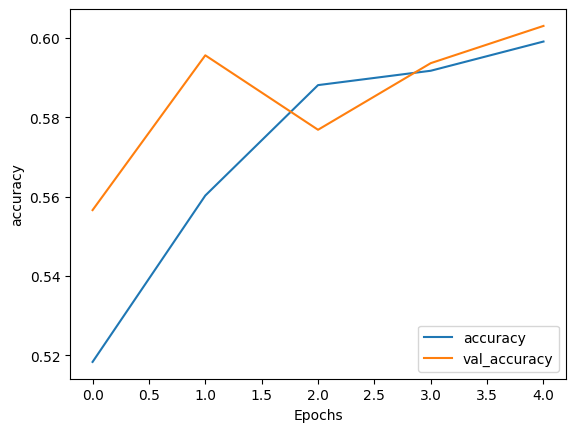

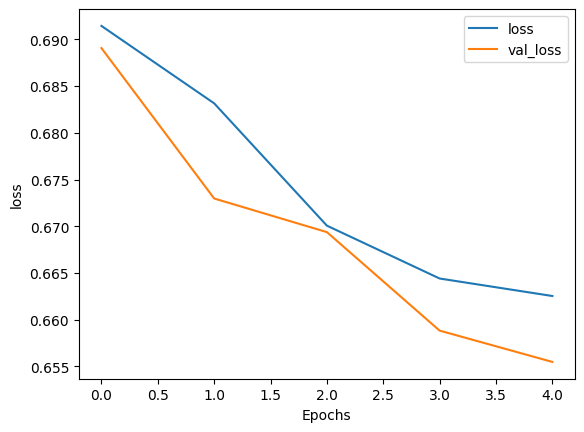

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
import numpy as np
from keras.preprocessing import image
from ipywidgets import FileUpload
from IPython.display import display

path = '/tmp/cats-v-dogs/validation/dog-2.jpg'
img = tf.keras.utils.load_img(path, target_size=(300, 300))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(classes)
print(classes[0])
if classes[0]>0.5:
    print("Image is a cat")
else:
    print("Image is a dog")

1/1 [==============================] - 0s 102ms/step
[[0.]]
[0.]
Image is a dog


In [8]:
export_dir = '/tmp/saved_model/DogsVsCats'
model.save(export_dir)

INFO:tensorflow:Assets written to: /tmp/saved_model/DogsVsCats\assets


INFO:tensorflow:Assets written to: /tmp/saved_model/DogsVsCats\assets


In [9]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [10]:
import pathlib
tflite_model_file = pathlib.Path('/tmp/saved_model/DogsVsCats/DogsVsCats.tflite')
tflite_model_file.write_bytes(tflite_model)

6821856

In [11]:
model.save('/tmp/saved_model/DogsVsCats/DogsVsCats.h5')